$$
\Large \textbf{Problema 02}
$$

<div style="text-align: justify">
Determine la deformación y los esfuerzos principales en función de la posición para una chapa con un agujero en el centro sujeta a tracción por sus extremos, como se muestra en la figura. Las dimensiones de la chapa son de $20\times10\:in$ y su espesor de una pulgada. El radio del agujero central es también de 1 pulgada.

Tome $E=30\cdot10^6\:psi$ y $\nu = 0.30$.

Analice el problema con número creciente de elementos y estudie su convergencia.
</div>

<center><img src="ImgProb02.png"></center>

***

In [1]:
import mef
import gmsh
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 7))
plt.rc('font', size=14)

## Datos del problema

In [2]:
L = 20    # in
W = 10    # in
t = 1     # in
r = 1     # in
E = 30e6  # psi
nu = 0.3
T = 1000  # psi

In [3]:
lc = 0.3

## Mallado

In [4]:
gmsh.initialize()

In [5]:
gmsh.model.add('Placa_agujero')

In [6]:
pO = gmsh.model.geo.addPoint(0, 0, 0, lc)
p1 = gmsh.model.geo.addPoint(0, r, 0, lc/15)
p2 = gmsh.model.geo.addPoint(0, W/2, 0, lc)
p3 = gmsh.model.geo.addPoint(L/2, W/2, 0, lc)
p4 = gmsh.model.geo.addPoint(L/2, 0, 0, lc)
p5 = gmsh.model.geo.addPoint(r, 0, 0, lc/15)

In [7]:
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p5)
c1 = gmsh.model.geo.addCircleArc(p5, pO, p1)

In [8]:
C1 = gmsh.model.geo.addCurveLoop([-c1, -l4, -l3, -l2, -l1])
S1 = gmsh.model.geo.addPlaneSurface([C1])
gmsh.model.geo.synchronize()

In [9]:
Empotrado_x = gmsh.model.addPhysicalGroup(1, [l1])
gmsh.model.setPhysicalName(1, Empotrado_x, 'Empotrado en x')
Empotrado_y = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1, Empotrado_y, 'Empotrado en y')

In [10]:
Traccionado = gmsh.model.addPhysicalGroup(1, [l3])
gmsh.model.setPhysicalName(1, Traccionado, 'Traccionado')

In [11]:
Superficie = gmsh.model.addPhysicalGroup(2, [S1])
gmsh.model.setPhysicalName(2, Superficie, 'Superficie')

In [12]:
gmsh.model.mesh.generate(2)     # Genera mallado de dimensión 2
gmsh.model.geo.synchronize()

## Matriz K

In [13]:
NodeInfo = gmsh.model.mesh.get_nodes()
Nn = NodeInfo[0].shape[0]
MN = NodeInfo[1].reshape(Nn, 3)
MN = np.append(MN[1:, :], [np.zeros(3)], 0)

In [14]:
Etags, Elements = gmsh.model.mesh.get_elements_by_type(2)
MC = Elements.reshape([Etags.shape[0], 3])
Ne, Nnxe = MC.shape
MC -= 1   # Acomoda índices a lenguaje Python

In [15]:
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
gmsh.write('Chapa_agujero.msh')

In [16]:
glxn = 2
dimension_el = 2
E = E*np.ones(Ne)

In [17]:
K, D, B = mef.Kglobal(MN, MC, E, glxn, dimension_el, nu, t)

## Condiciones de contorno

In [18]:
NodosEmpotradosX, xyz_empotrados_x = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_x)
NodosEmpotradosY, xyz_empotrados_y = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_y)
s = []
for n in NodosEmpotradosX-1:
    s.append(glxn*n)
for n in NodosEmpotradosY-1:
    s.append(glxn*n+1)
s.append((NodeInfo[0][0]-1)*glxn)
s.append((NodeInfo[0][0]-1)*glxn+1)
s = np.array(s).astype(int)
Us = np.zeros([s.shape[0]]).reshape([-1, 1])

r = np.array([i for i in range(glxn*MN.shape[0]) if i not in s])

In [19]:
entityTracc = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)
Tgroup, Ttracc, Ltracc = gmsh.model.mesh.getElements(1, entityTracc[0])
Nlineastracc = len(Ttracc[0])
MCtracc = Ltracc[0].reshape(Nlineastracc, 2)-1

In [20]:
Fr = np.zeros_like(r)
for e in range(Nlineastracc):
    n1 = MCtracc[e, 0].astype(int)
    n2 = MCtracc[e, 1].astype(int)
    Ltracc = abs(MN[n2, 1]-MN[n1, 1])
    Fr[np.where(r == n1*2)[0][0]] += T*Ltracc*t/2
    Fr[np.where(r == n2*2)[0][0]] += T*Ltracc*t/2
Fr = Fr.reshape([-1, 1])

## Solución

In [21]:
F, U = mef.solve(K, r, Fr, s, Us)

In [22]:
sig = {}
d = {}
for e in range(Ne):
    nodo = MC[e, :].astype(int)
    d[e] = np.array([U[nodo[0]*glxn], U[nodo[0]*glxn+1],
                     U[nodo[1]*glxn], U[nodo[1]*glxn+1],
                     U[nodo[2]*glxn], U[nodo[2]*glxn+1]]).reshape([-1, 1])
    sig[e] = D[e].dot(B[e].dot(d[e]))

In [23]:
U2D = U.reshape(Nn, glxn)
U3D = np.append(U2D, np.zeros(U2D.shape[0]).reshape([-1, 1]), 1)

In [24]:
MNdef = MN+U3D*1e4

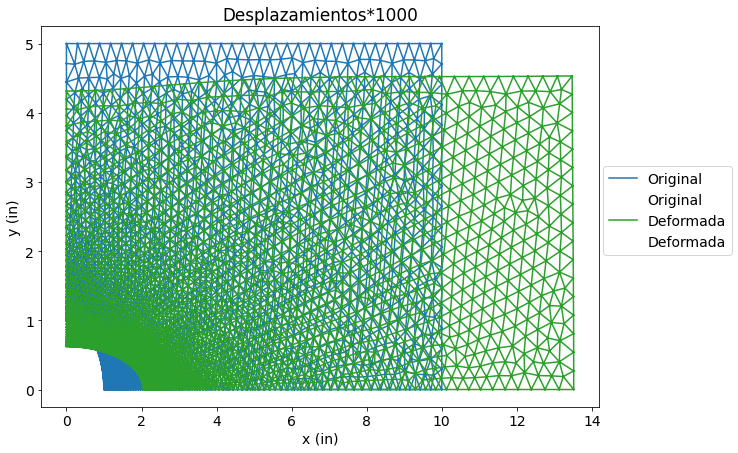

In [25]:
plt.triplot(MN[:, 0], MN[:, 1], MC, label='Original')
plt.triplot(MNdef[:, 0], MNdef[:, 1], MC, label='Deformada')
plt.legend(bbox_to_anchor=(1.25, 0.65))
plt.title('Desplazamientos*1000')
plt.ylabel('y (in)')
plt.xlabel('x (in)')
plt.show()

## Visualización en GMSH

In [26]:
desps = gmsh.view.add("Desplazamientos")
Desps = gmsh.view.addModelData(desps, 0, 'Placa_agujero', 'NodeData', NodeInfo[0], U3D, numComponents=3)
gmsh.option.setNumber(f'View[{desps}].VectorType', 5)

In [27]:
F2D = F.reshape(Nn, glxn)
F3D = np.append(F2D, np.zeros(F2D.shape[0]).reshape([-1, 1]), 1)
fuerzas = gmsh.view.add('Fuerzas')
Fuerzas = gmsh.view.addModelData(fuerzas, 0, 'Placa_agujero', 'NodeData', NodeInfo[0], F3D, numComponents=3)
gmsh.option.setNumber(f'View[{fuerzas}].VectorType', 4)
gmsh.option.setNumber(f'View[{fuerzas}].GlyphLocation', 2)

In [28]:
sig_xytau = np.hstack(list(sig.values()))
sigx = gmsh.view.add('Tensiones en x')
sigy = gmsh.view.add('Tensiones en y')
sigxy = gmsh.view.add('Tensiones xy')
SIGX = gmsh.view.addModelData(sigx, 0, 'Placa_agujero', 'ElementData', Etags, sig_xytau[0,:].reshape([-1,1]), numComponents=1)
SIGY = gmsh.view.addModelData(sigy, 0, 'Placa_agujero', 'ElementData', Etags, sig_xytau[1,:].reshape([-1,1]), numComponents=1)

In [29]:
gmsh.fltk.run()

#### Resultados:

<center><img src="ImpPtProb02_1.png"></center>
<center><img src="ImpPtProb02_2.png"></center>
<center><img src="ImpPtProb02_3.png"></center>